# Species Classification Model

## 1. Initialization

In [0]:
# Set up Tensorflow 2.0

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

In [2]:
# Import libraries

# General
import csv
import os
import numpy as np
from collections import defaultdict
import random
random.seed(42)

# Pretrained Models
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as VGG16Pre
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as XceptionPre
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as MNPre

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import pickle
from sklearn.model_selection import train_test_split

# Model Configuration
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam

# Model Training
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# Others
from keras.preprocessing import image as KImage

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
# Mount Google Drive - Note this mounts your personal Google Drive to the directory stated
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Preprocessing

### 2-1. Data Load

Images are loaded from csv files that contain previously processed datasets.
The preprocessing implementation can be found here: https://colab.research.google.com/drive/1tVg9y71wbf_-bpgOue4LAFbCSXuu2SCD?usp=sharing

In [0]:
# Initial model configuration setting based on the value given in the variable "BASE_MODEL"
BASE_MODEL="vgg16"  #Choices are: vgg16, mobilenetv2, xception

if BASE_MODEL=='vgg16':
  train_imagefile="Training-Images-224.csv"
  train_labelfile="Training-Labels-224.txt"
  test_imagefile="Test-Images-224.csv"
  test_labelfile="Test-Labels-224.txt"
  input_shape=(224,224,3)
  zero_model=VGG16(weights='imagenet',include_top=False,input_shape=input_shape,)
  saved_model_filename='species_classification_vgg16_model.h5'
  preprocessor=VGG16Pre

elif BASE_MODEL=="mobilenetv2":
  train_imagefile="Train-Images-Mobile-224.csv"
  train_labelfile="Train-Labels-Mobile-224.txt"
  test_imagefile="Test-Images-Mobile-224.csv"
  test_labelfile="Test-Labels-Mobile-224.txt"
  input_shape=(224,224,3)
  zero_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape)
  saved_model_filename='species_classification_mobilenetv2_model.h5'
  preprocessor=MNPre

elif BASE_MODEL=="xception":
  train_imagefile="Training-Images-Xception-224.csv"
  train_labelfile="Training-Labels-Xception-224.txt"
  test_imagefile="Test-Images-Xception-224.csv"
  test_labelfile="Test-Labels-Xception-224.txt"
  input_shape=(224,224,3)
  zero_model=Xception(weights='imagenet',include_top=False,input_shape=input_shape)
  saved_model_filename='species_classification_xception_model.h5'
  preprocessor=XceptionPre

The following code loads both train and test dataset and their corresponding labels from the given Google Drive directory.

In [0]:
# Set up path for csv files containing preprocessed images. Change subfolder names to match your setup in Google Drive.
csvpath='/content/drive/My Drive/U C Berkeley - Darragh/csv'

# Function to load processed image data in csv files (both training and test data and their corresponding labels)
def LoadData(train_imagefile=train_imagefile, train_labelfile=train_labelfile,
             test_imagefile=test_imagefile, test_labelfile=test_labelfile, input_shape=input_shape):
  # Training Dataset
  X=[]
  Individuals=[]
  Species=[]

  dataset=np.loadtxt(os.path.join(csvpath,train_imagefile),delimiter=",")
  f=open(os.path.join(csvpath,train_labelfile),'r')
  lines=f.readlines()
  for line in lines:
      vals=line.rstrip()
      Species.append(vals.split("-")[0])
      Individuals.append(vals)

  i=0
  for x in dataset:
    image=x.reshape(input_shape)
    X.append(image)

  # Test Dataset
  X_Test=[]
  Individuals_Test=[]
  Species_Test=[]
  dataset=np.loadtxt(os.path.join(csvpath,test_imagefile),delimiter=",")

  for x in dataset:
    image=x.reshape(input_shape)
    X_Test.append(image)

  f=open(os.path.join(csvpath,test_labelfile),'r')
  lines=f.readlines()
  
  for line in lines:
    vals=line.rstrip()
    Species_Test.append(vals.split("-")[0])
    Individuals_Test.append(vals)

  X_Test=np.asarray(X_Test)
  X=np.asarray(X)
  return(X,Species,Individuals,X_Test,Species_Test,Individuals_Test)

In [0]:
# Load pre-processed images

X,Species,Individuals,X_Test,Species_Test,Individuals_Test=LoadData(train_imagefile=train_imagefile, train_labelfile=train_labelfile,
               test_imagefile=test_imagefile, test_labelfile=test_labelfile, input_shape=input_shape)

# Use this line for augmented images
##X,Species,Individuals,Ind_DB,X_Test,Species_Test,Individuals_Test=LoadData(train_imagefile="Training-Images-224.csv",train_labelfile="Training-Labels-224.txt", 
##                                                                           test_imagefile="Test-Images-224.csv",test_labelfile="Test-Labels-224.txt")

### 2-2. Label Transformation
Since the original target values(labels) are species text values, those values are categorized. After the transformation, labels are stored as arrays with 11(number of classes of species) binary values where only the index of the species that a given footprint image belongs to has a value of 1.

In [7]:
# Label encoding
le = LabelEncoder()
le.fit(Species)
Y=le.transform(Species)
Y_Test=le.transform(Species_Test)
Y1=to_categorical(np.array(Y))
Y_Test1=to_categorical(np.array(Y_Test))
print(Y1.shape)
print(le.classes_)
num_species=len(le.classes_)

(1690, 11)
['African elephant' 'African lion' 'Amur Tiger' 'Bengal Tiger'
 'Black Rhino' 'Bongo' 'Cheetah' 'Leopard' 'Lowland Tapir' 'Puma'
 'White Rhino']


In [0]:
fp=open(os.path.join(csvpath,"species_list.pickle"), "wb")
pickle.dump(le.classes_, fp)
fp.close()

### 2-3. Data Split
The final step in data preprocessing before the modeling is to split the dataset into train and test(validation) dataset. 9:1 data split ratio is applied to the dataset - 90% of the dataset is used to train the model, and the remaining 10% is used to validate the model in the end.

In [0]:
# Train & Test data split
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X, Y1, test_size=0.10, random_state=42)

In [10]:
len(X_Train)
len(Y_Train)

1521

## 3. Model Development

### 3-1. Base Model
The following code sets up the base model by customizing the pre-trained model(`zero_model`) that was assigned in the beginning:
1. It sets all layers in the pre-trained model as trainable - no frozen layers.
2. It adds additional layers.

In [11]:
tf.keras.backend.clear_session()
#vgg=VGG16(weights='imagenet',include_top=False,input_shape=input_shape)

#Set all layers of pretrained VGG16 model as trainable. Add a few dense layers on top
zero_model.trainable=True 

spec_model=Sequential()
spec_model.add(zero_model)
spec_model.add(Flatten())
spec_model.add(Dropout(0.2))
spec_model.add(Dense(256, activation='relu',name="Embedding"))
spec_model.add(Dropout(0.1))
spec_model.add(Dense(128, activation='relu'))
spec_model.add(Dropout(0.1))
spec_model.add(Dense(64, activation='relu'))
spec_model.add(Dropout(0.1))
spec_model.add(Dense(num_species))

spec_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
Embedding (Dense)            (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

### 3-2. Model Training
The following code trains the base model defined above with the optimal hyperparameters that were identified in our multiple trials. Some examples of the hyperparameters that were altered to enhance the model are optimizer, loss function, metrics, and number of epochs.

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

mc = ModelCheckpoint(os.path.join(csvpath,saved_model_filename), monitor='val_loss', mode='min')

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
spec_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000005),
                   loss=loss_fn,
                   metrics=['accuracy'])

#STATIC
spec_model.fit(X_Train,Y_Train,validation_data=(X_Val,Y_Val),batch_size=32,epochs=90,verbose=2,callbacks=[es,mc])

#DYNAMIC ** Note: tried Validation without augmentation (from above) and got ~20% accuracy..
#history = vgg_model.fit_generator(training_generator,steps_per_epoch=(len(X_Train))//32, validation_data=validation_generator,validation_steps=len(X_Val)//32,epochs=30)

Epoch 1/90
48/48 - 15s - loss: 3.5785 - accuracy: 0.0927 - val_loss: 2.3388 - val_accuracy: 0.1775
Epoch 2/90
48/48 - 12s - loss: 2.4763 - accuracy: 0.1486 - val_loss: 2.1546 - val_accuracy: 0.2959
Epoch 3/90
48/48 - 12s - loss: 2.3004 - accuracy: 0.2130 - val_loss: 2.0276 - val_accuracy: 0.3314
Epoch 4/90
48/48 - 12s - loss: 2.1409 - accuracy: 0.2761 - val_loss: 1.8887 - val_accuracy: 0.4260
Epoch 5/90
48/48 - 12s - loss: 1.9732 - accuracy: 0.3439 - val_loss: 1.6946 - val_accuracy: 0.5030
Epoch 6/90
48/48 - 12s - loss: 1.7485 - accuracy: 0.4497 - val_loss: 1.4997 - val_accuracy: 0.5917
Epoch 7/90
48/48 - 12s - loss: 1.5785 - accuracy: 0.4872 - val_loss: 1.3124 - val_accuracy: 0.6746
Epoch 8/90
48/48 - 12s - loss: 1.3403 - accuracy: 0.5720 - val_loss: 1.0862 - val_accuracy: 0.6746
Epoch 9/90
48/48 - 12s - loss: 1.1371 - accuracy: 0.6469 - val_loss: 0.9368 - val_accuracy: 0.7574
Epoch 10/90
48/48 - 12s - loss: 0.9557 - accuracy: 0.6930 - val_loss: 0.7460 - val_accuracy: 0.7751
Epoch 11/

### 3-3. Model Evaluation
The trained model is then evaluated based on the test dataset that was loaded in the beginning of data preprocessing (that were not included in training and validating the model). The model is evaluated by measuring its accuracy. Then, further analysis is performed to break down the details on the accuracy to grasp more in-depth understanding on its performance.

#### 3-3-1. Initial Evaluation
The below code is meant to be run right after training (assuming that the model is already in memory).*italicized text*

In [13]:
# Evaluate on test data WITHOUT augmentation
spec_model.evaluate(X_Test, Y_Test1, verbose=2)

7/7 - 1s - loss: 0.2137 - accuracy: 0.9265


[0.21371199190616608, 0.9264705777168274]

In [14]:
# Accuracy breakdown by species
import numpy as np
predictions = spec_model.predict(X_Test)
for idx, species in enumerate(le.classes_):
  total_count = 0
  correct_count = 0
  result_idx = 0
  for row in Y_Test1:
    if row[idx] == 1:
      total_count += 1
      predicted_value = np.argmax(predictions[result_idx]).item()
      if predicted_value == idx:
        correct_count += 1
    result_idx += 1
  print("Accuracy of "+species+" =",correct_count/total_count*100,"%")
  print(" Total =",total_count,", Correct Predictions =",correct_count)

Accuracy of African elephant = 78.26086956521739 %
 Total = 23 , Correct Predictions = 18
Accuracy of African lion = 92.85714285714286 %
 Total = 28 , Correct Predictions = 26
Accuracy of Amur Tiger = 100.0 %
 Total = 11 , Correct Predictions = 11
Accuracy of Bengal Tiger = 100.0 %
 Total = 16 , Correct Predictions = 16
Accuracy of Black Rhino = 87.5 %
 Total = 16 , Correct Predictions = 14
Accuracy of Bongo = 100.0 %
 Total = 19 , Correct Predictions = 19
Accuracy of Cheetah = 100.0 %
 Total = 24 , Correct Predictions = 24
Accuracy of Leopard = 71.42857142857143 %
 Total = 14 , Correct Predictions = 10
Accuracy of Lowland Tapir = 91.66666666666666 %
 Total = 12 , Correct Predictions = 11
Accuracy of Puma = 100.0 %
 Total = 27 , Correct Predictions = 27
Accuracy of White Rhino = 92.85714285714286 %
 Total = 14 , Correct Predictions = 13


#### 3-3-2. Confusion Matrix
The following code transforms the prediction output values of the model to the same format as the actual values that were prepared in the last step of data preprocessing so that they are comparable prior to building a confusion matrix. Then, the confusion matrix plotted using a heatmap for easy visibility of the details of the model performance.

In [15]:
# Create a prediction result that aligns with the actual target values instead of probabilities
pred_new = []
arr_len = len(le.classes_)
for idx in predictions:
  new_array = [0 for i in range(arr_len)]
  max_idx = np.argmax(idx)
  new_array[max_idx] = 1
  pred_new.append(new_array)
pred_new = np.asarray(pred_new)
print(pred_new.shape)
print(Y_Test1.shape)

(204, 11)
(204, 11)


In [16]:
# Create a confusion matrix
df_confusion = []
for num in range(arr_len):
  df_confusion.append([0] * arr_len)

df_confusion = np.asarray(df_confusion)

for pred, act in zip(pred_new, Y_Test1):
  pred_idx = np.where(pred == 1)[0][0]
  act_idx = np.where(act == 1)[0][0]
  df_confusion[act_idx][pred_idx] += 1
df_confusion

array([[18,  0,  0,  0,  3,  0,  0,  0,  0,  0,  2],
       [ 0, 26,  0,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0, 11,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 24,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0, 10,  0,  1,  1],
       [ 0,  0,  1,  0,  0,  0,  0,  0, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 27,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 13]])

The following confusion matrix plot shows how many footprint images are correctly and incorrectly predicted by the model. Row values are actual species, and column values represent predicted species.

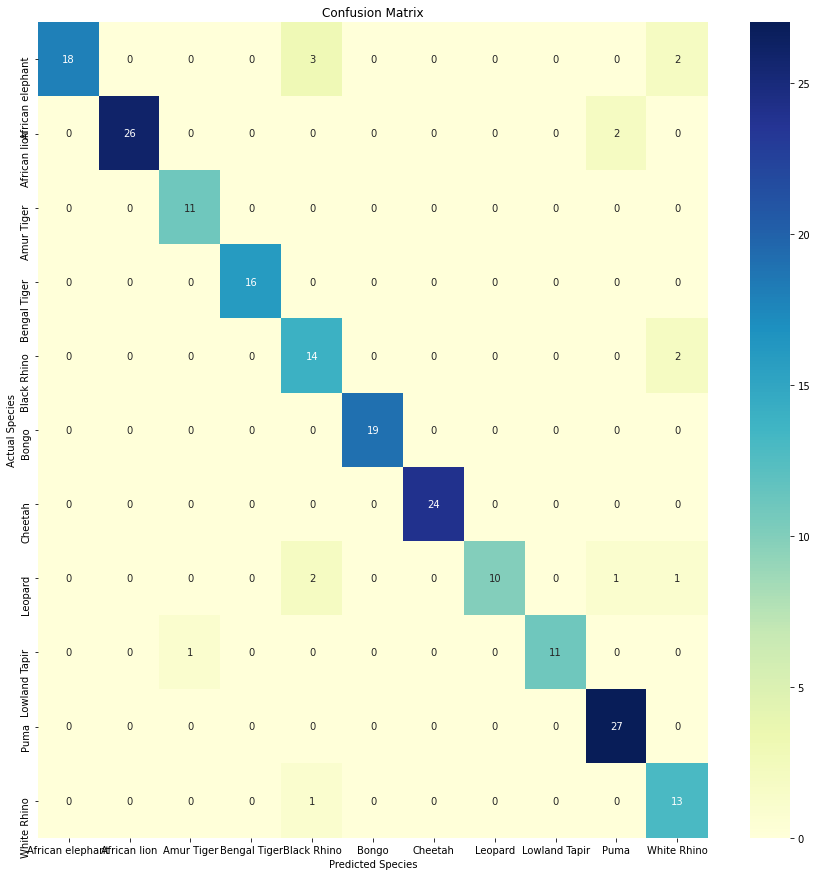

In [17]:
# Plot a confusion matrix with heatmap  
fig = plt.figure(figsize=(15, 15))
ax= fig.add_subplot()
sns.heatmap(df_confusion, annot=True, ax = ax, cmap="YlGnBu") #annot=True to annotate cells

# Add labels, title, and ticks
ax.set_xlabel('Predicted Species');ax.set_ylabel('Actual Species')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(le.classes_); ax.yaxis.set_ticklabels(le.classes_)

# Save plot
fig.savefig('/content/drive/My Drive/U C Berkeley - Darragh/Presentations/species_classification_confusion_matrix.png')

### 3-4. Model Reload and Evaluation
The following code extracts the model weights saved in the previous step from the given directory and re-evaluates the model.

In [0]:
spec_model.load_weights(os.path.join(csvpath,saved_model_filename))
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
spec_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
                   loss=loss_fn,
                   metrics=['accuracy'])

In [19]:
#test_generator = datagen.flow(X_Test, Y_Test1, batch_size=32,shuffle=True,seed=7)
spec_model.evaluate(X_Test,  Y_Test1, verbose=2)

7/7 - 0s - loss: 0.2137 - accuracy: 0.9265


[0.21371199190616608, 0.9264705777168274]

In [20]:
len(X_Test)

204

## 4. Visualization of Results

In [0]:
def plotprints(df):
  dfx=df.drop(['y','Names'],axis=1)
  tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
  tsne_results = tsne.fit_transform(dfx)
  df['tsne-2d-one'] = tsne_results[:,0]
  df['tsne-2d-two'] = tsne_results[:,1]
  plt.figure(figsize=(16,10))
  num=df['Names'].nunique()

  sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                  hue="Names",
                  palette=sns.color_palette("hls", num),
                  data=df,
                  legend="full",
                  alpha=0.6)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1690 samples in 0.008s...
[t-SNE] Computed neighbors for 1690 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1690
[t-SNE] Computed conditional probabilities for sample 1690 / 1690
[t-SNE] Mean sigma: 3.285073
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.471397
[t-SNE] KL divergence after 300 iterations: 0.732476


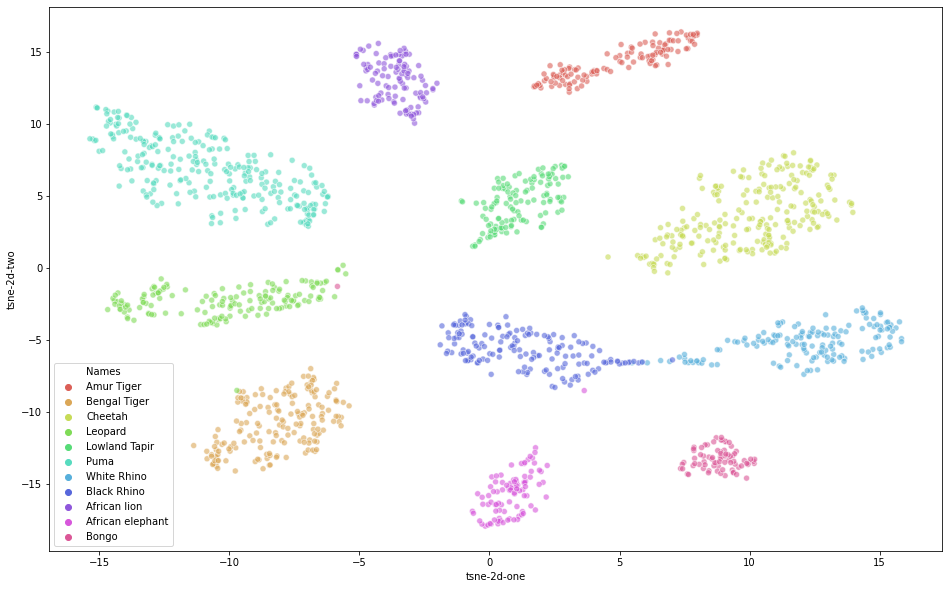

In [22]:
Y=le.transform(Species)
X_encoded=spec_model.predict(X)
df=pd.DataFrame(X_encoded)
df['y']=Y
df['Names']=Species
# Plot projected 2D clusters for each species
plotprints(df)

## 5. Appendix

### 5-1. Testing Inference

In [23]:
# Set all layers of pretrained VGG16 model as trainable. Add a few dense layers on top.
trained_model=Sequential()
trained_model.add(zero_model)
trained_model.add(Flatten())
trained_model.add(Dropout(0.4))
trained_model.add(Dense(256, activation='relu',name="Dense1"))
trained_model.add(Dense(128, activation='relu'))
trained_model.add(Dense(64, activation='relu'))
trained_model.add(Dropout(0.4))
trained_model.add(Dense(num_species))

trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
Dense1 (Dense)               (None, 256)               6422784   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [0]:
trained_model.load_weights(os.path.join(csvpath,saved_model_filename))
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
trained_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),
                      loss=loss_fn,
                      metrics=['accuracy'])

In [0]:
# Load Data
# Function to load and individual image to a specified size.
def load_image(image,preprocessor,size=(224,224)):
  try:
    image = KImage.load_img(image,target_size=size,interpolation="nearest")
  except:
    return np.zeros(0)
  else:
    x= KImage.img_to_array(image)
    x = np.expand_dims(x, axis=0)
    x = preprocessor(x)
    x=np.squeeze(x)
    #x=x.reshape(-1)
    return x

def LoadDataSet(folder,preprocessor,size=(224,224)):
  Prints=[]
  Instances=[]
  Individuals=[]
  for instance in os.listdir(folder):
    ind_path=folder+'/'+instance
    for footprint in os.listdir(ind_path):
      x=load_image(os.path.join(ind_path,footprint),preprocessor,(224,224))
      if x.shape[0]==0:
        continue
      else:
        Prints.append(x)
        Instances.append(instance)
        Individuals.append(footprint)
  return Prints,Instances,Individuals

In [26]:
inferencepath="/content/drive/My Drive/U C Berkeley - Darragh/TX2 Inference/Data"
Prints,Instances,Individuals=LoadDataSet(inferencepath,preprocessor,(224,224))

FileNotFoundError: ignored

In [0]:
X=np.asarray(Prints)
Y_logits=np.absolute(trained_model.predict(X))
Y=np.argmax(Y_logits,1)
Y_Species=le.inverse_transform(Y)

In [0]:
Y_logits[0]

In [0]:
for i in range(len(Prints)):
  print(Y_Species[i],Individuals[i])